# **Set-up**

Terminal command:

```console
pip install numpy
pip install pandas
pip install openpyxl
pip install datetime
pip install matplotlib
```

Import packages needed for notebook:

In [49]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Ensure current working directory is in "EC1B1" folder

# **Read Excel**

In [50]:
df_spain_raw = pd.read_excel('./data/data_spain.xlsx')
df_us_raw = pd.read_excel('./data/data_united_states.xlsx')

We save dataframe in another variable to keep the raw data untouched

In [51]:
spain_1 = df_spain_raw
us_1 = df_us_raw

Inspect the dataframe

In [52]:
spain_1.head()

,International Financial Statistics (IFS),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currenc...","International Reserves and Liquidity, Reserves...","Prices, Consumer Price Index, All items, Index"
1,Jan 1960,NaN,0.016667,233,2.857368
2,Feb 1960,NaN,0.016667,253,2.855049
3,Mar 1960,NaN,0.016667,299,2.851573
4,Apr 1960,NaN,0.016667,326,2.853891


# **Initial Cleaning**

## For Spain:

In [53]:
spain_2 = spain_1 \
    .rename(columns={'International Financial Statistics (IFS)': 'date', 'Unnamed: 1': 'spain_industrial_index', 'Unnamed: 2': 'spain_nominal_exchange_rate', 'Unnamed: 3': 'spain_reserves', 'Unnamed: 4': 'spain_price_index'}) \
    .dropna()

In [54]:
spain_3 = spain_2
spain_3['spain_nominal_exchange_rate'] = spain_3['spain_nominal_exchange_rate'].apply(lambda x: 1/x)

In [55]:
spain_4 = spain_3
spain_4['date'] = spain_4['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

In [56]:
spain_5 = spain_4
spain_columns = ['spain_industrial_index', 'spain_nominal_exchange_rate', 'spain_reserves', 'spain_price_index']
for column in spain_columns:
    spain_5[column] = pd.to_numeric(spain_5[column])
    spain_5[column] = spain_5[column].round(2)

In [57]:
spain_5.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index
13,1961-01-01,18.68,60.0,536.00,2.91
14,1961-02-01,18.25,60.0,565.00,2.89
15,1961-03-01,18.42,60.0,561.55,2.87
16,1961-04-01,18.61,60.0,593.50,2.88
17,1961-05-01,19.58,60.0,643.50,2.87


In [58]:
spain_basic_cleaned = spain_5

## Using similar codes, repeat for US:

In [59]:
# Repeat first step using code from Spain
us_1 = us_1 \
    .rename(columns={'International Financial Statistics (IFS)': 'date', 'Unnamed: 1': 'us_reserves', 'Unnamed: 2': 'us_price_index'}) \
    .dropna()

# Tidy the data using similar process
us_1['date'] = us_1['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

for column in ['us_reserves', 'us_price_index']:
    us_1[column] = pd.to_numeric(us_1[column])
    us_1[column] = us_1[column].round(2)

us_basic_cleaned = us_1

In [60]:
us_basic_cleaned.head()

,date,us_reserves,us_price_index
1,1960-01-01,21478.1,13.44
2,1960-02-01,21395.7,13.48
3,1960-03-01,21344.7,13.48
4,1960-04-01,21278.0,13.53
5,1960-05-01,21234.3,13.53


# **Data manipulation**

Define real exchange rate

In [61]:
merged_1 = pd.merge(spain_basic_cleaned, us_basic_cleaned, on = 'date')

Create the lag variables:

In [62]:
# For Spain
merged_1['spain_nominal_exchange_rate_lag_1'] = merged_1['spain_nominal_exchange_rate'].shift(1)
merged_1['spain_price_index_lag_1'] = merged_1['spain_price_index'].shift(1)
merged_1['spain_industrial_index_lag_1'] = merged_1['spain_industrial_index'].shift(1)
merged_1['spain_industrial_index_lag_12'] = merged_1['spain_industrial_index'].shift(12)

# For US
merged_1['us_price_index_lag_1'] = merged_1['us_price_index'].shift(1)

# Save as new dataframe
merged_2 = merged_1

In [63]:
merged_2.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1
0,1961-01-01,18.68,60.0,536.00,2.91,19056.2,13.67,NaN,NaN,NaN,NaN,NaN
1,1961-02-01,18.25,60.0,565.00,2.89,18978.0,13.67,60.0,2.91,18.68,NaN,13.67
2,1961-03-01,18.42,60.0,561.55,2.87,18988.2,13.67,60.0,2.89,18.25,NaN,13.67
3,1961-04-01,18.61,60.0,593.50,2.88,19165.1,13.67,60.0,2.87,18.42,NaN,13.67
4,1961-05-01,19.58,60.0,643.50,2.87,19196.9,13.67,60.0,2.88,18.61,NaN,13.67


In [64]:
merged_2['spain_nominal_exchange_rate_growth'] = (merged_2['spain_nominal_exchange_rate'] - merged_2['spain_nominal_exchange_rate_lag_1']) / merged_2['spain_nominal_exchange_rate_lag_1'] * 100
merged_2['spain_real_exchange_rate'] = merged_2['spain_nominal_exchange_rate'] * merged_2['us_price_index'] / merged_2['spain_price_index']
merged_2['spain_real_exchange_rate_lag_1'] = merged_2['spain_real_exchange_rate'].shift(1)
merged_2['spain_real_exchange_rate_growth'] = (merged_2['spain_real_exchange_rate'] - merged_2['spain_real_exchange_rate_lag_1']) / merged_2['spain_real_exchange_rate_lag_1'] * 100
merged_2['spain_inflation_rate'] = (merged_2['spain_price_index'] - merged_2['spain_price_index_lag_1']) / merged_2['spain_price_index_lag_1'] * 100
merged_2['spain_industrial_growth'] = (merged_2['spain_industrial_index'] - merged_2['spain_industrial_index_lag_1']) / merged_2['spain_industrial_index_lag_1'] * 100
merged_2['spain_industrial_yearly_growth'] = (merged_2['spain_industrial_index'] - merged_2['spain_industrial_index_lag_12']) / merged_2['spain_industrial_index_lag_12'] * 100
merged_2['us_inflation_rate'] = (merged_2['us_price_index'] - merged_2['us_price_index_lag_1']) / merged_2['us_price_index_lag_1'] * 100
merged_3 = merged_2
merged_3.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate
0,1961-01-01,18.68,60.0,536.00,2.91,19056.2,13.67,NaN,NaN,NaN,NaN,NaN,NaN,281.855670,NaN,NaN,NaN,NaN,NaN,NaN
1,1961-02-01,18.25,60.0,565.00,2.89,18978.0,13.67,60.0,2.91,18.68,NaN,13.67,0.0,283.806228,281.855670,0.692042,-0.687285,-2.301927,NaN,0.0
2,1961-03-01,18.42,60.0,561.55,2.87,18988.2,13.67,60.0,2.89,18.25,NaN,13.67,0.0,285.783972,283.806228,0.696864,-0.692042,0.931507,NaN,0.0
3,1961-04-01,18.61,60.0,593.50,2.88,19165.1,13.67,60.0,2.87,18.42,NaN,13.67,0.0,284.791667,285.783972,-0.347222,0.348432,1.031488,NaN,0.0
4,1961-05-01,19.58,60.0,643.50,2.87,19196.9,13.67,60.0,2.88,18.61,NaN,13.67,0.0,285.783972,284.791667,0.348432,-0.347222,5.212251,NaN,0.0


In [65]:
spain_index_list = []
us_index_list = []
spain_first_value = merged_3.loc[0, 'spain_reserves']
us_first_value = merged_3.loc[0, 'us_reserves']

for value in merged_3['spain_reserves']:
    if value != None:
        index = value / spain_first_value * 100
    else:
        index = None

    spain_index_list.append(index)

for value in merged_3['us_reserves']:
    if value != None:
        index = value / us_first_value * 100
    else:
        index = None

    us_index_list.append(index)

merged_3['spain_reserves_index_1960'] = spain_index_list
merged_3['us_reserves_index_1960'] = us_index_list
merged_4 = merged_3
merged_4.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_nominal_exchange_rate_growth,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
0,1961-01-01,18.68,60.0,536.00,2.91,19056.2,13.67,NaN,NaN,NaN,...,NaN,281.855670,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000
1,1961-02-01,18.25,60.0,565.00,2.89,18978.0,13.67,60.0,2.91,18.68,...,0.0,283.806228,281.855670,0.692042,-0.687285,-2.301927,NaN,0.0,105.410448,99.589635
2,1961-03-01,18.42,60.0,561.55,2.87,18988.2,13.67,60.0,2.89,18.25,...,0.0,285.783972,283.806228,0.696864,-0.692042,0.931507,NaN,0.0,104.766791,99.643161
3,1961-04-01,18.61,60.0,593.50,2.88,19165.1,13.67,60.0,2.87,18.42,...,0.0,284.791667,285.783972,-0.347222,0.348432,1.031488,NaN,0.0,110.727612,100.571468
4,1961-05-01,19.58,60.0,643.50,2.87,19196.9,13.67,60.0,2.88,18.61,...,0.0,285.783972,284.791667,0.348432,-0.347222,5.212251,NaN,0.0,120.055970,100.738342


In [66]:
df = merged_4

# **5.3.1**

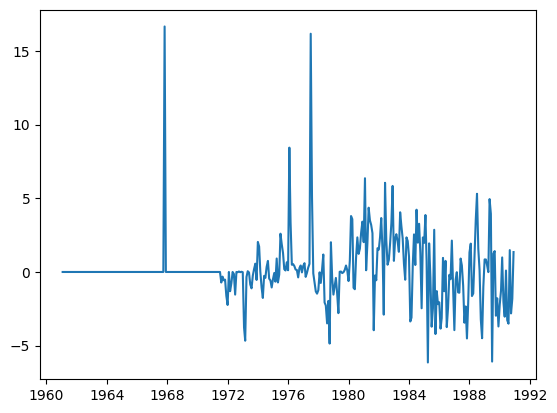

In [67]:
plt.plot(df['date'], df['spain_nominal_exchange_rate_growth'])

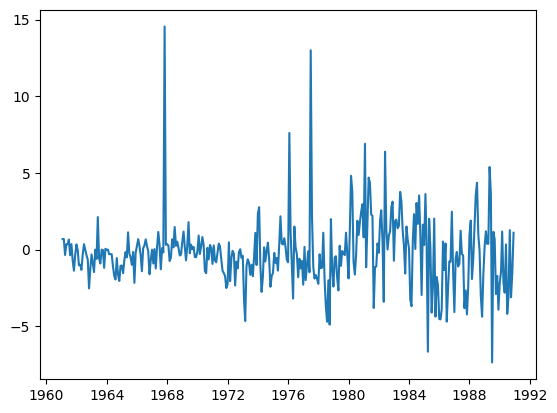

In [68]:
plt.plot(df['date'], df['spain_real_exchange_rate_growth'])

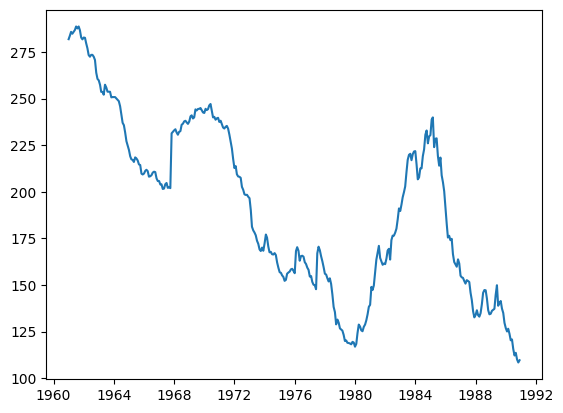

In [69]:
plt.plot(df['date'], df['spain_real_exchange_rate'])

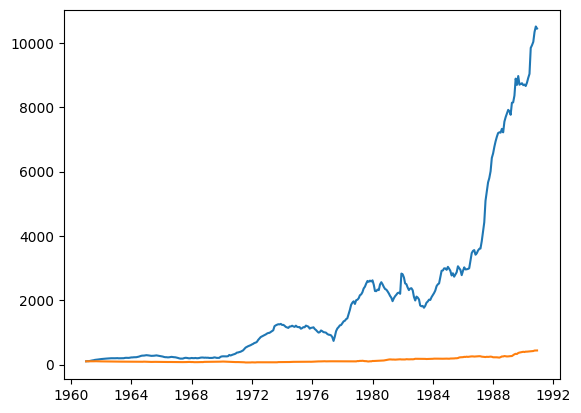

In [70]:
# Remember change to until 1973
plt.plot(df['date'], df['spain_reserves_index_1960'])
plt.plot(df['date'], df['us_reserves_index_1960'])

# **5.3.2**

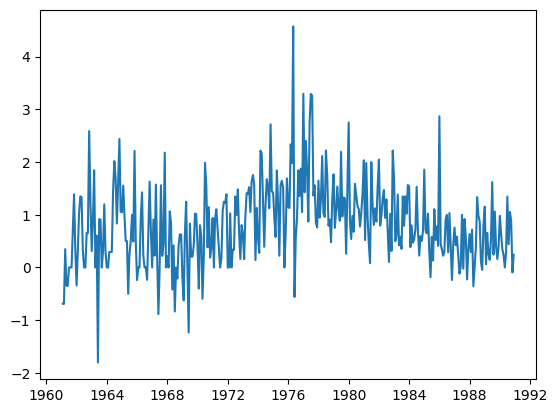

In [71]:
plt.plot(df['date'], df['spain_inflation_rate'])

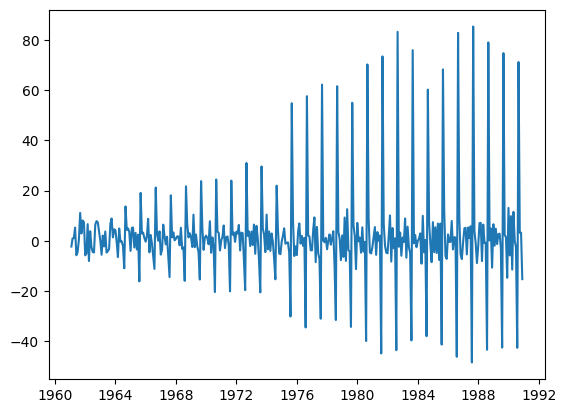

In [72]:
plt.plot(df['date'], df['spain_industrial_growth'])

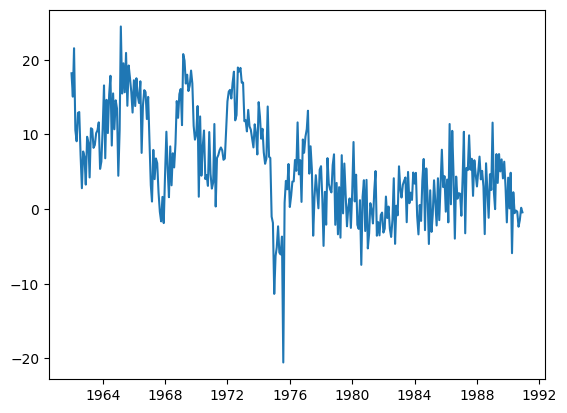

In [73]:
plt.plot(df['date'], df['spain_industrial_yearly_growth'])

# **5.3.3**